# 02 Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options)

## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles (X = features, y = labels)
X, y = make_circles(n_samples, # num of samples
                    noise=0.03, # randomness
                    random_state=42) # basically setting a seed

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


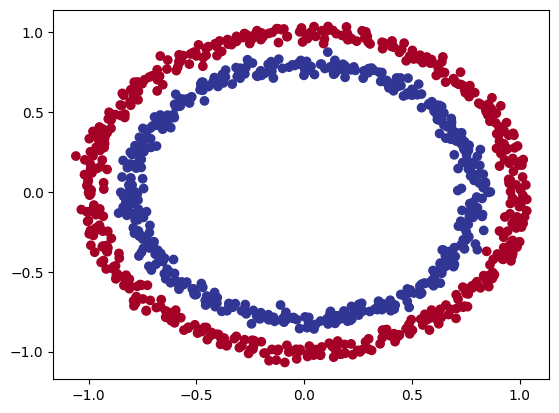

In [6]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

**Note**: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment on but still sizeable enough to practice the fundamentals

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test sets

In [10]:
import torch
torch.__version__

'2.3.0+cu121'

In [11]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [13]:
# Split data into trainng and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% of data will be test & 80& will be train)
                                                    random_state=42) # like torch.manual_seed

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [15]:
n_samples

1000

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [16]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass of the model_selection
4. Instantiate an instance of our model class and send it to the target `device`

In [17]:
X_train.shape # the second digit here is important because it's the # of in_features for first layer

torch.Size([800, 2])

In [18]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, # takes in 2 features
                             out_features=5) # upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, # must match prev layer out_features
                             out_features=1) # output/prediction

    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
      return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4737,  0.1446],
                      [ 0.4649, -0.4468],
                      [ 0.6491, -0.2986],
                      [ 0.6481, -0.5840],
                      [-0.5671,  0.2767]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.2331, -0.1128, -0.4846,  0.6486,  0.5173], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.1778, -0.3114, -0.2205, -0.1339,  0.3631]], device='cuda:0')),
             ('1.bias', tensor([-0.3657], device='cuda:0'))])

In [21]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.3844],
        [ 0.3040],
        [ 0.1387],
        [ 0.4559],
        [-0.5855],
        [-0.6289],
        [-0.2811],
        [-0.5014],
        [ 0.1696],
        [ 0.2907]], device='cuda:0')

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

This is problem specific.

For example, for regression you might want MAE or MSE (mean absolute error or mean squared error)

For classification, you might want a binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how wrong your models predictions are

And for optimizers, two of the most common and useful are SGD and Adam, however, PyTorch has many built-in options.

* For the loss function we're going to use `torch.nn.BECWithLogitsLoss()`

In [22]:
# Setup the loss function
# loss_fn = nn.BCELoss() # <- requires inputs to have gone through the sigmoid activationd function prior to input
loss_fn = nn.BCEWithLogitsLoss() # <- signoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [23]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # checks how many are equal between y_true and y_pred
  acc = (correct/len(y_pred)) * 100
  return acc

## Train model

##  3. Train model

To train our model, we're going to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model ouptuts are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (eg sigmoid for binary crossentrophy and softmax for multiclass classification).

Then we can convert our model's prediction probabiliites to **prediction labels** by either rounding them or taking the `argmax()`

In [24]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval() # whenever you make predictions, put into eval mode and use inference mode. just have to remember to put back into train mode for training loop
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.3844],
        [ 0.3040],
        [ 0.1387],
        [ 0.4559],
        [-0.5855]], device='cuda:0')

In [25]:
# Use the sigmoid activation function on our model logits ot turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5949],
        [0.5754],
        [0.5346],
        [0.6120],
        [0.3577]], device='cuda:0')

In [26]:
y_test[:5] # we need y_logits to look like this

tensor([1., 0., 1., 0., 1.])

For our prediction probability values, we need to perform a range-style rounding on them:
* y_pred_probs >= 0.5, y=1 (class 1)
* y_pred_probs < 0.5, y=0 (class 0)

In [27]:
# ... and here's how we do it
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]], device='cuda:0')

## All in one!

In [28]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (raw logits -> prediction probabilities -> prediction labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 0.], device='cuda:0')

### 3.2 Building a training and testing loop

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluating loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate the loss/accuracy
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_0(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))
      # 2. Caculate loss/accuracy
      test_loss = loss_fn(test_logits,
                          y_test)
      test_acc = accuracy_fn(y_true=y_test,
                              y_pred=test_pred)

  # Print out what's happening every 10 epochs
  if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71446, Accuracy: 49.50% | Test loss: 0.71511, Test acc: 50.50%
Epoch: 10 | Loss: 0.70594, Accuracy: 49.38% | Test loss: 0.70766, Test acc: 50.50%
Epoch: 20 | Loss: 0.70096, Accuracy: 49.50% | Test loss: 0.70321, Test acc: 51.00%
Epoch: 30 | Loss: 0.69797, Accuracy: 49.75% | Test loss: 0.70046, Test acc: 50.50%
Epoch: 40 | Loss: 0.69613, Accuracy: 49.50% | Test loss: 0.69872, Test acc: 50.50%
Epoch: 50 | Loss: 0.69498, Accuracy: 49.88% | Test loss: 0.69760, Test acc: 51.50%
Epoch: 60 | Loss: 0.69426, Accuracy: 49.75% | Test loss: 0.69687, Test acc: 51.50%
Epoch: 70 | Loss: 0.69380, Accuracy: 50.50% | Test loss: 0.69638, Test acc: 49.00%
Epoch: 80 | Loss: 0.69351, Accuracy: 50.38% | Test loss: 0.69605, Test acc: 47.50%
Epoch: 90 | Loss: 0.69332, Accuracy: 50.00% | Test loss: 0.69582, Test acc: 47.50%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it, let's make some predictions and make them visual!

To do so, we're going to import a function called `plot_decision_boundary()`

In [30]:
import requests # let's us use other people's code
from pathlib import Path # let's us make file paths

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

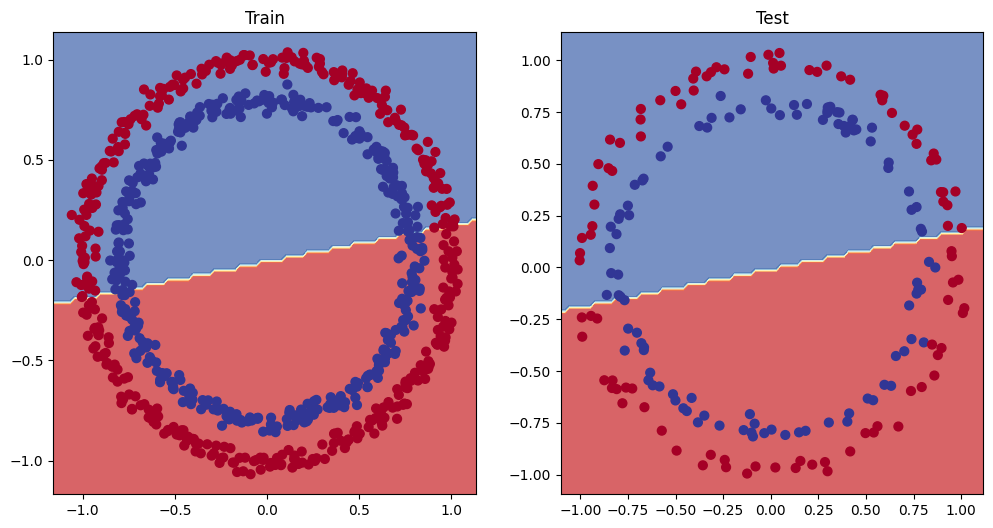

In [31]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2) # rows, cols, index
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer (maybe more epochs)
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we can change, they are referred to as **hyperparameters**

* We want to change things one at a time so we know what's exactly offering the improvements

In [32]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10) # adding more hidden units (5 -> 10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # do previous steps (commented out) all in one! leverages speedups where possible BTS

model_1 = CircleModelV1().to(device)
model_1


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [34]:
# Set seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set num of epochs
epochs = 1000 # Train for longer (improvement)

# Device agnostic code
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Write a training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_1.train()
  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> pred layers

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train) # using y_logits bc we're using BCEWithLogitsLoss()
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69396, Acc: 50.88 | Test loss 0.69261, Test acc: 51.00
Epoch: 100 | Loss: 0.69305, Acc: 50.38 | Test loss 0.69379, Test acc: 48.00
Epoch: 200 | Loss: 0.69299, Acc: 51.12 | Test loss 0.69437, Test acc: 46.00
Epoch: 300 | Loss: 0.69298, Acc: 51.62 | Test loss 0.69458, Test acc: 45.00
Epoch: 400 | Loss: 0.69298, Acc: 51.12 | Test loss 0.69465, Test acc: 46.00
Epoch: 500 | Loss: 0.69298, Acc: 51.00 | Test loss 0.69467, Test acc: 46.00
Epoch: 600 | Loss: 0.69298, Acc: 51.00 | Test loss 0.69468, Test acc: 46.00
Epoch: 700 | Loss: 0.69298, Acc: 51.00 | Test loss 0.69468, Test acc: 46.00
Epoch: 800 | Loss: 0.69298, Acc: 51.00 | Test loss 0.69468, Test acc: 46.00
Epoch: 900 | Loss: 0.69298, Acc: 51.00 | Test loss 0.69468, Test acc: 46.00


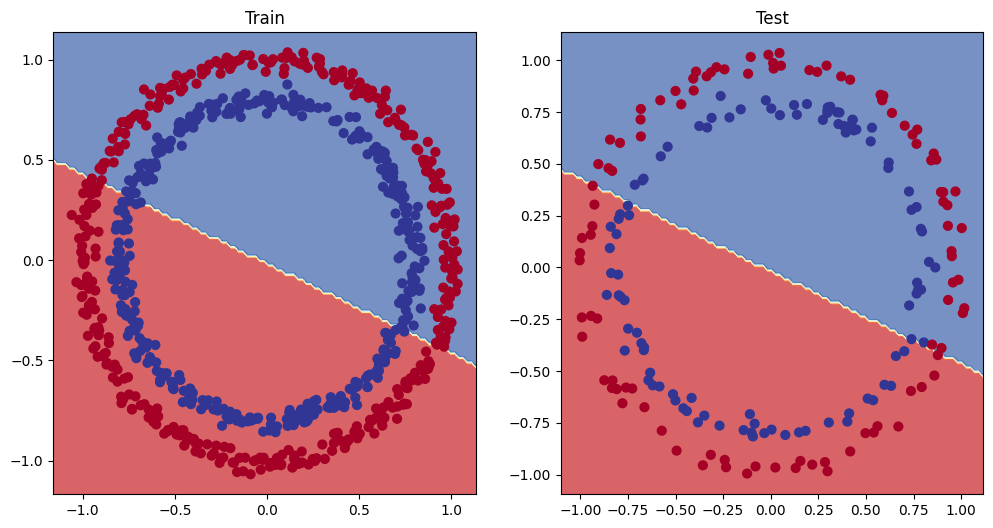

In [35]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2) # rows, cols, index
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshott to a larger problem is to test out a smaller problem.

In [36]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [37]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

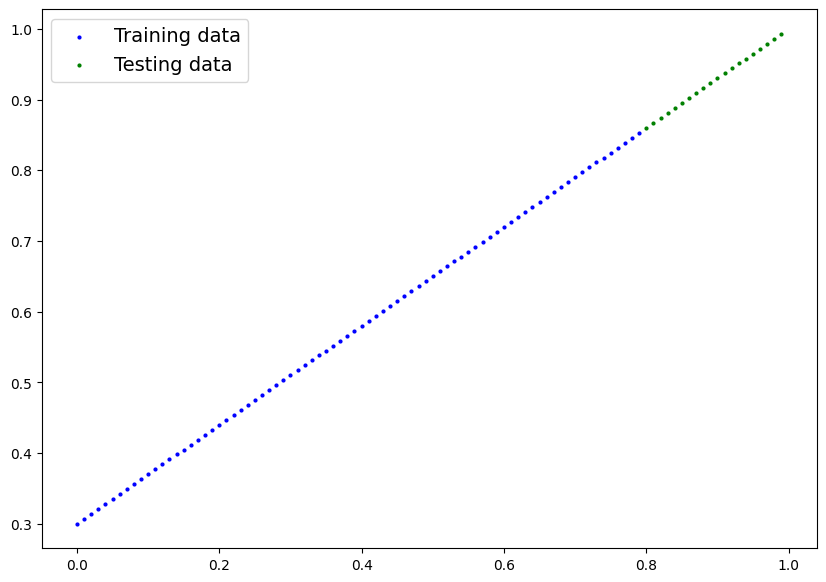

In [38]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [39]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

In [40]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [41]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.91103
Epoch: 100 | Train loss: 0.02858, Test loss: 0.00081
Epoch: 200 | Train loss: 0.02533, Test loss: 0.00209
Epoch: 300 | Train loss: 0.02137, Test loss: 0.00305
Epoch: 400 | Train loss: 0.01964, Test loss: 0.00341
Epoch: 500 | Train loss: 0.01940, Test loss: 0.00387
Epoch: 600 | Train loss: 0.01903, Test loss: 0.00379
Epoch: 700 | Train loss: 0.01878, Test loss: 0.00381
Epoch: 800 | Train loss: 0.01840, Test loss: 0.00329
Epoch: 900 | Train loss: 0.01798, Test loss: 0.00360


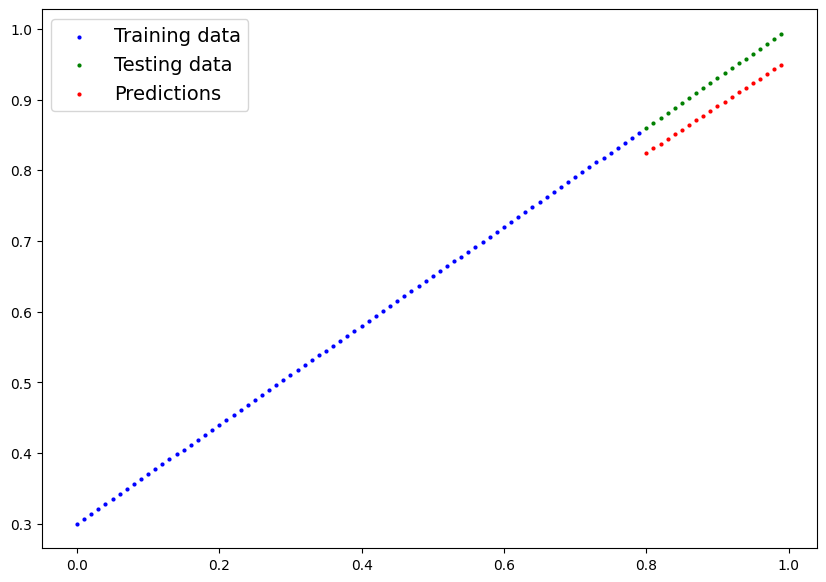

In [42]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of straight and non-straight lines?"

Or in ML terms, an infinite (really is finite) amount of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

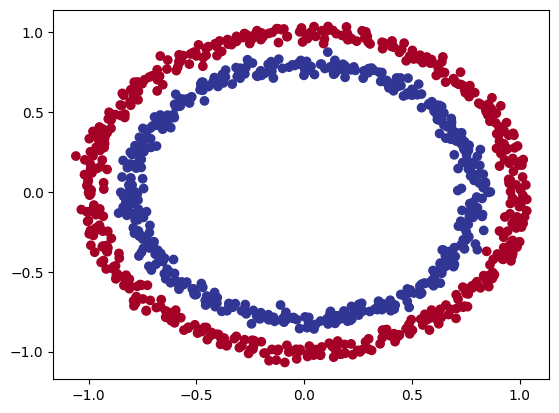

In [43]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [44]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## 6.2 Building a model with non-linearity

In [45]:
from os import X_OK
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=32) # in_features is # of cols in X_train (shown above)
    self.layer_2 = nn.Linear(in_features=32, out_features=32)
    self.layer_3 = nn.Linear(in_features=32, out_features=1)
    self.relu = nn.ReLU() # non-linear activation function

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [46]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

### 6.3 Training a model with non-linearity

In [47]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 3000

for epoch in range(epochs):
  ### Training
  model_3.train()\

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch: 0 | Loss: 0.6947, Acc: 46.88 | Test Loss: 0.6944, Test Acc: 47.0000
Epoch: 100 | Loss: 0.6896, Acc: 58.13 | Test Loss: 0.6896, Test Acc: 58.5000
Epoch: 200 | Loss: 0.6838, Acc: 66.00 | Test Loss: 0.6844, Test Acc: 64.5000
Epoch: 300 | Loss: 0.6743, Acc: 73.12 | Test Loss: 0.6762, Test Acc: 77.5000
Epoch: 400 | Loss: 0.6554, Acc: 81.38 | Test Loss: 0.6595, Test Acc: 81.5000
Epoch: 500 | Loss: 0.6152, Acc: 94.75 | Test Loss: 0.6243, Test Acc: 91.5000
Epoch: 600 | Loss: 0.5298, Acc: 99.50 | Test Loss: 0.5470, Test Acc: 99.0000
Epoch: 700 | Loss: 0.3772, Acc: 99.75 | Test Loss: 0.4058, Test Acc: 99.0000
Epoch: 800 | Loss: 0.2172, Acc: 99.88 | Test Loss: 0.2538, Test Acc: 99.5000
Epoch: 900 | Loss: 0.1208, Acc: 99.88 | Test Loss: 0.1568, Test Acc: 99.5000
Epoch: 1000 | Loss: 0.0743, Acc: 99.88 | Test Loss: 0.1056, Test Acc: 99.5000
Epoch: 1100 | Loss: 0.0506, Acc: 100.00 | Test Loss: 0.0778, Test Acc: 99.5000
Epoch: 1200 | Loss: 0.0372, Acc: 100.00 | Test Loss: 0.0612, Test Acc: 99.5

### 6.4 Evaluating a model trained with non-linear activation functions

In [48]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

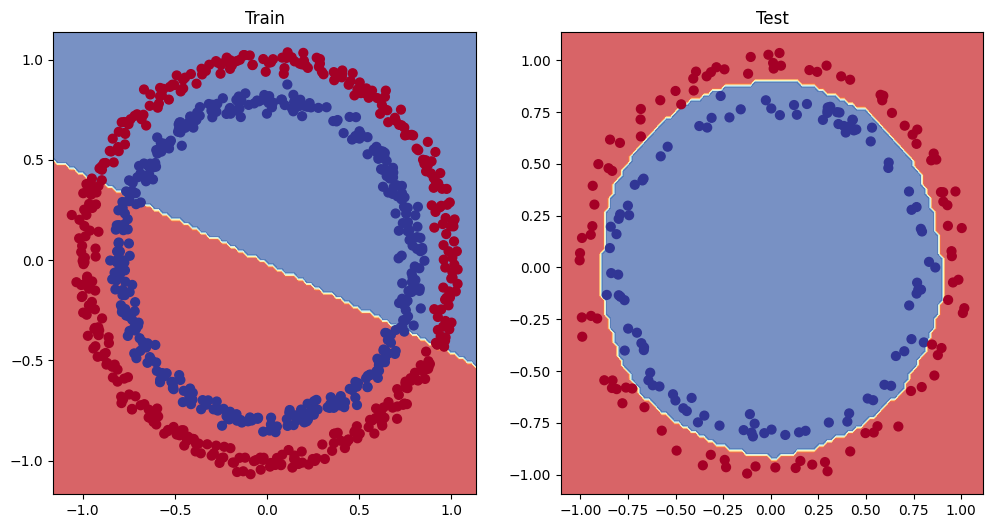

In [49]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

Neural networks, rather than telling the model what to learn, we give it the tools to discover patterns in data and patterns on its own.

These tools are linear and non-linear functions.

In [50]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

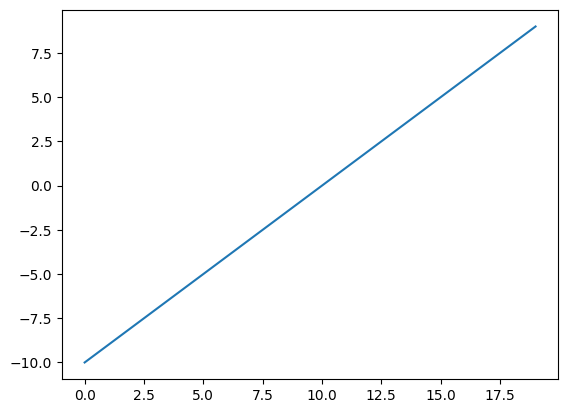

In [51]:
# Visualize the tensor
plt.plot(A);

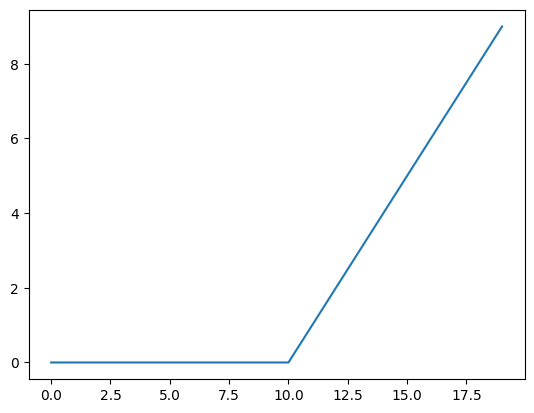

In [52]:
plt.plot(torch.relu(A));

In [53]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

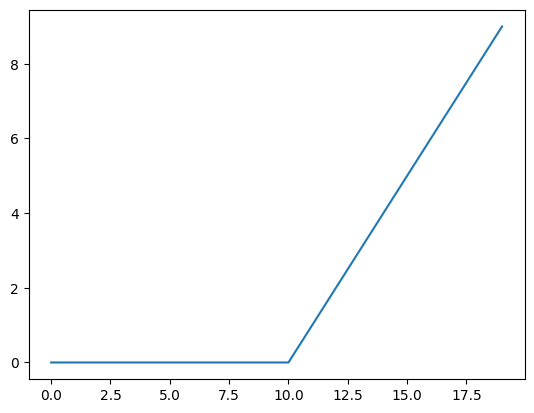

In [54]:
plt.plot(relu(A))

In [55]:
# Now let's do the same for sigmoid
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

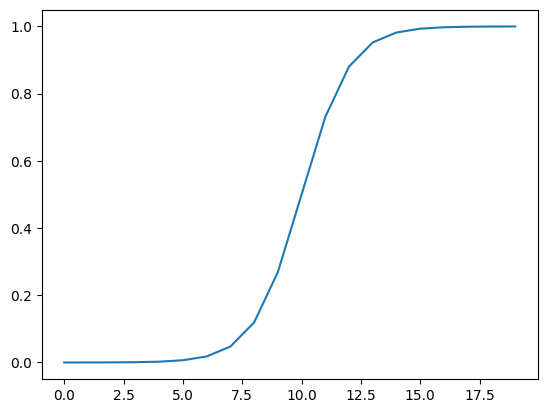

In [56]:
plt.plot(torch.sigmoid(A));

### 8. Putting it all together with a multi-class classification problem

* Binary classification: one thing or another (eg spam vs. not spam, etc.)
* Multi-class classification: more than one thing or another

### Creating a toy multi-class dataset

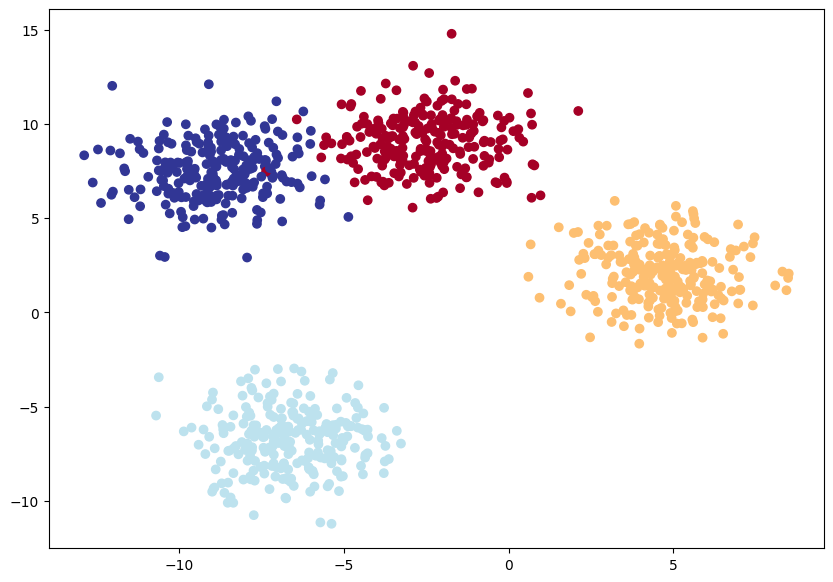

In [57]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)


# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2 Building a multi-class classification model in PyTorch

In [58]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [59]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2, # Shape of X
                    output_features=4, # Num of classes
                    hidden_units=8).to(device) # Not neccessary as already defined in constructor

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [60]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

Logits (raw output of the model) -> Pred probs (use `torch.softmax`)-> Pred labels (take the argmax of the prediction probabilities)

In [61]:
# Let's get some raw outputs of our model
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [62]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [63]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch Model

In [64]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f} | Test loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.1588, Acc: 40.38 | Test loss: 1.0755, Test Acc: 48.00
Epoch: 10 | Loss: 0.6448, Acc: 96.75 | Test loss: 0.6607, Test Acc: 97.50
Epoch: 20 | Loss: 0.4254, Acc: 98.50 | Test loss: 0.4307, Test Acc: 100.00
Epoch: 30 | Loss: 0.2529, Acc: 99.12 | Test loss: 0.2451, Test Acc: 99.50
Epoch: 40 | Loss: 0.1123, Acc: 99.25 | Test loss: 0.1023, Test Acc: 99.50
Epoch: 50 | Loss: 0.0663, Acc: 99.25 | Test loss: 0.0585, Test Acc: 99.50
Epoch: 60 | Loss: 0.0507, Acc: 99.25 | Test loss: 0.0429, Test Acc: 99.50
Epoch: 70 | Loss: 0.0430, Acc: 99.25 | Test loss: 0.0349, Test Acc: 99.50
Epoch: 80 | Loss: 0.0384, Acc: 99.25 | Test loss: 0.0299, Test Acc: 99.50
Epoch: 90 | Loss: 0.0352, Acc: 99.25 | Test loss: 0.0266, Test Acc: 99.50


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [65]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [66]:
# Go from logits -> prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [67]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

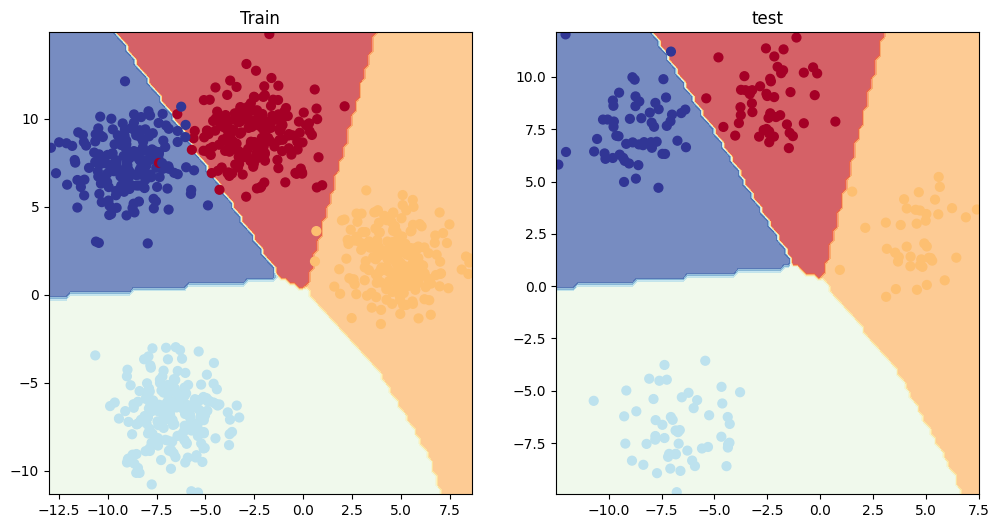

In [68]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 19.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)


In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)